# Read csv files

In [239]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
os.makedirs("outputs", exist_ok=True)

def read_file():
    """
    Reads a CSV file and returns a DataFrame.
    """
    csv_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data", "csv")
    print("CSV directory:", csv_dir)
    csv_files = glob.glob(os.path.join(csv_dir, "sf_crime_*.csv.gz"))
    print("CSV files found:", csv_files)

    if csv_files:
        file_path = max(csv_files, key=os.path.getctime)
    else:
        return None

    try:
        df = pd.read_csv(file_path, compression='gzip', low_memory=False)

        # Convert 'incident_datetime' to datetime and extract hour, weekday, and month
        df['incident_datetime'] = pd.to_datetime(df['incident_datetime'], errors='coerce')
        df['incident_hour'] = df['incident_datetime'].dt.hour
        df['incident_month'] = df['incident_datetime'].dt.month
        df = df.dropna(subset=['latitude', 'longitude', 'incident_datetime', 'incident_category'])


        print(f"df shape: {df.shape}")
        print(f"df columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

df = read_file()
        

CSV directory: /Users/chichichen/Code/ecs273-team08-CrimeForecast/data/csv
CSV files found: ['/Users/chichichen/Code/ecs273-team08-CrimeForecast/data/csv/sf_crime_20240530_20250524.csv.gz']
df shape: (65988, 30)
df columns: ['incident_datetime', 'incident_date', 'incident_time', 'incident_year', 'incident_day_of_week', 'report_datetime', 'row_id', 'incident_id', 'incident_number', 'cad_number', 'report_type_code', 'report_type_description', 'incident_code', 'incident_category', 'incident_subcategory', 'incident_description', 'resolution', 'intersection', 'cnn', 'police_district', 'analysis_neighborhood', 'supervisor_district', 'supervisor_district_2012', 'latitude', 'longitude', 'point', 'filed_online', 'location', 'incident_hour', 'incident_month']


Combined categories into two types

In [240]:
def categorize_crime_violent(category):
    """
    Base on this reference https://onlinelibrary.wiley.com/doi/full/10.1155/2022/4830411
    We categorized the category into Violent and Non-Violent
    """
    violent = {
        'Assault', 'Robbery', 'Homicide', 'Rape',
        'Weapons Offense', 'Weapons Carrying Etc',
        'Sex Offense', 'Offences Against The Family And Children',
        'Suicide', 'Human Trafficking (A), Commercial Sex Acts',
        'Human Trafficking, Commercial Sex Acts'
    }

    if category in violent:
        return 'Violent'
    else:
        return 'Non-Violent'

def categirize_crime_occupation(category):
    """"
    Base on this reference https://cs229.stanford.edu/proj2015/228_report.pdf
    We categorized the category into Blue and White Collar
    """
    blue_collar = {
        'Assault', 'Robbery', 'Burglary', 'Motor Vehicle Theft', 'Larceny Theft',
        'Malicious Mischief', 'Vandalism', 'Drug Offense',
        'Weapons Offense', 'Weapons Carrying Etc',
        'Homicide', 'Rape', 'Sex Offense',
        'Disorderly Conduct', 'Prostitution', 'Suicide',
        'Human Trafficking (A), Commercial Sex Acts',
        'Human Trafficking, Commercial Sex Acts',
        'Traffic Violation Arrest', 'Traffic Collision',
        'Arson', 'Stolen Property', 'Civil Sidewalks',
        'Suspicious', 'Recovered Vehicle',
    }
    if category in blue_collar:
        return 'Blue-Collar'
    else:
        return 'White-Collar'

df['crime_type_violent'] = df['incident_category'].apply(categorize_crime_violent)
df['crime_type_occupation'] = df['incident_category'].apply(categirize_crime_occupation)


# 1. Crime Categories

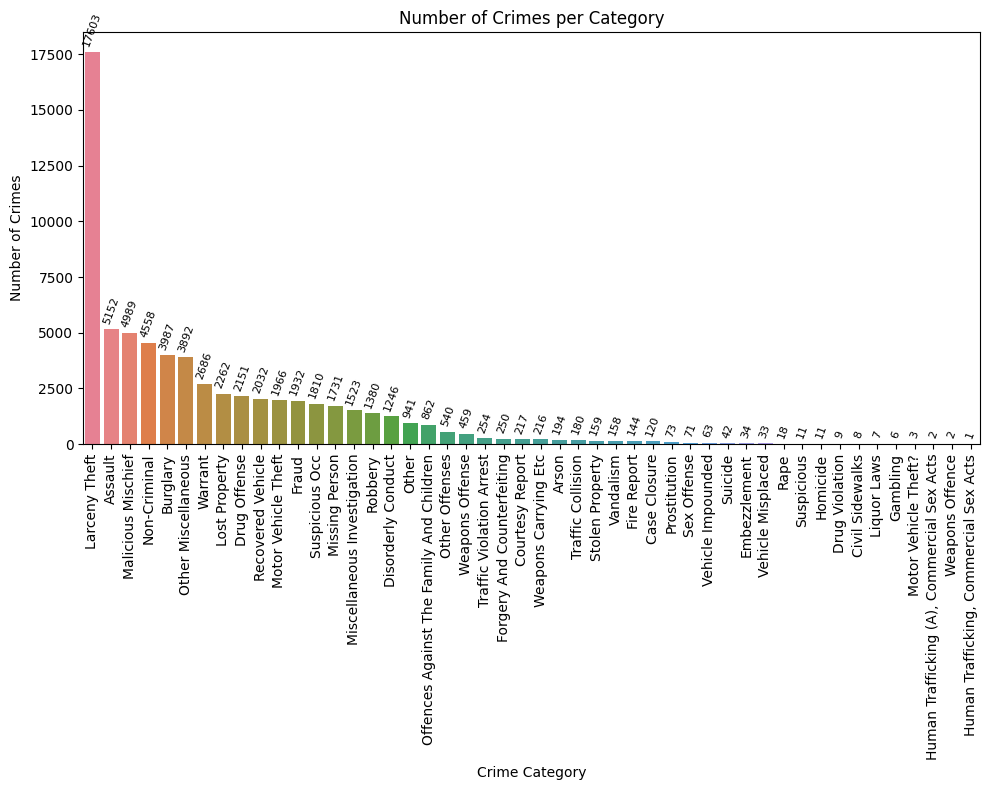

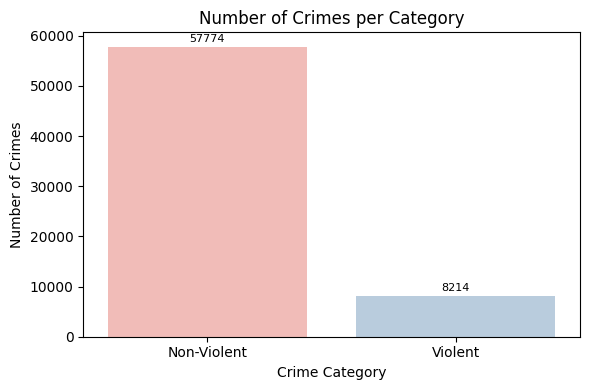

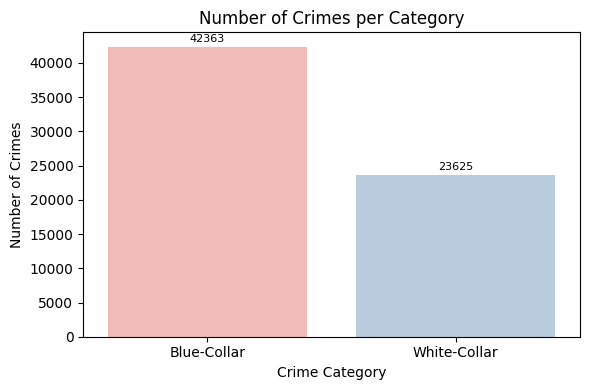

In [241]:
def plot_crime_categories(col_name, img_name='org'):

    category_counts = df[col_name].value_counts()

    if img_name=='org':
        plt.figure(figsize=(10, 8))
        rotation, rotation_l, pattle = 90, 70, 'husl'
    else:
        plt.figure(figsize=(6,4))
        rotation, rotation_l, pattle = 0, 0, 'Pastel1'

    
    palette = sns.color_palette(pattle, len(category_counts))
    ax = sns.barplot(
        x=category_counts.index,
        y=category_counts.values,
        palette=palette,
        hue=category_counts.index
    )

    for i, v in enumerate(category_counts.values):
        ax.text(i, v + max(category_counts.values)*0.01, str(v), ha='center', va='bottom', fontsize=8, rotation=rotation_l)


    plt.xticks(rotation=rotation)

    plt.title("Number of Crimes per Category")
    plt.xlabel("Crime Category")
    plt.ylabel("Number of Crimes")

    plt.tight_layout()

    plt.savefig(f"outputs/crime_categories_{img_name}.png", dpi=300)
    plt.show()

plot_crime_categories('incident_category','org')
plot_crime_categories('crime_type_violent','violent')
plot_crime_categories('crime_type_occupation','occupation')


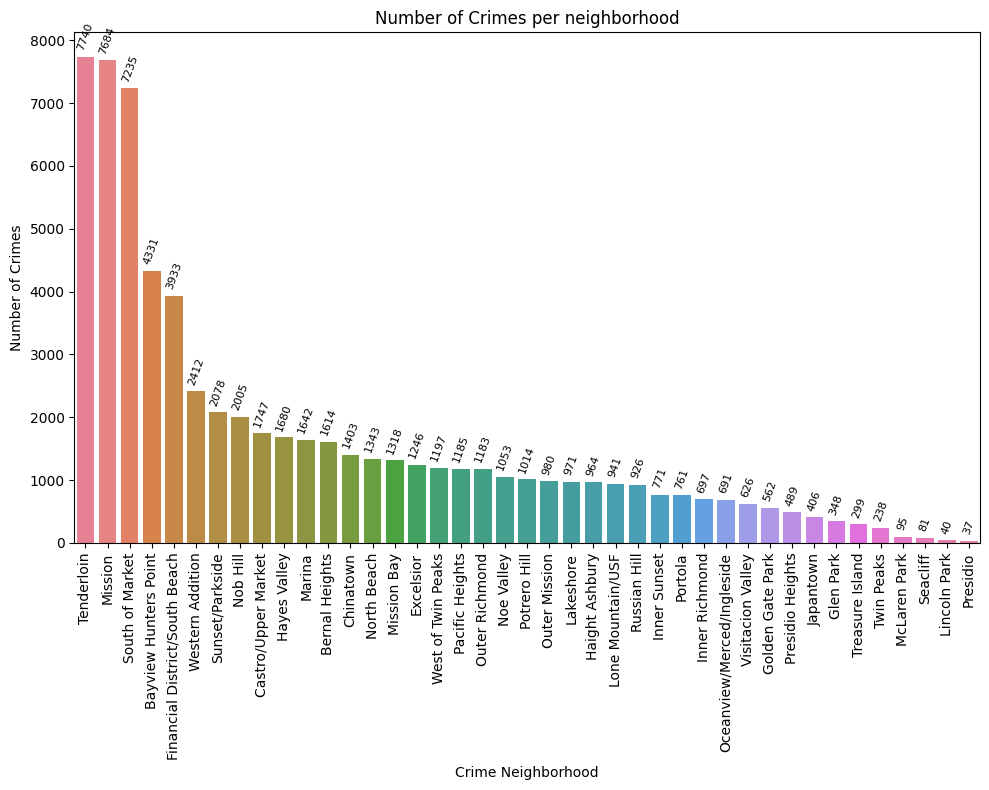

In [242]:
category_counts = df['analysis_neighborhood'].value_counts()

plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(category_counts))

ax = sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    palette=palette,
    hue=category_counts.index
)

for i, v in enumerate(category_counts.values):
    ax.text(i, v + max(category_counts.values)*0.01, str(v), ha='center', va='bottom', fontsize=8, rotation=70)


plt.xticks(rotation=90)

plt.title("Number of Crimes per neighborhood")
plt.xlabel("Crime Neighborhood")
plt.ylabel("Number of Crimes")

plt.tight_layout()

plt.savefig("outputs/crime_neighborhoods.png", dpi=300)
plt.show()

# 2. Crime by Hour

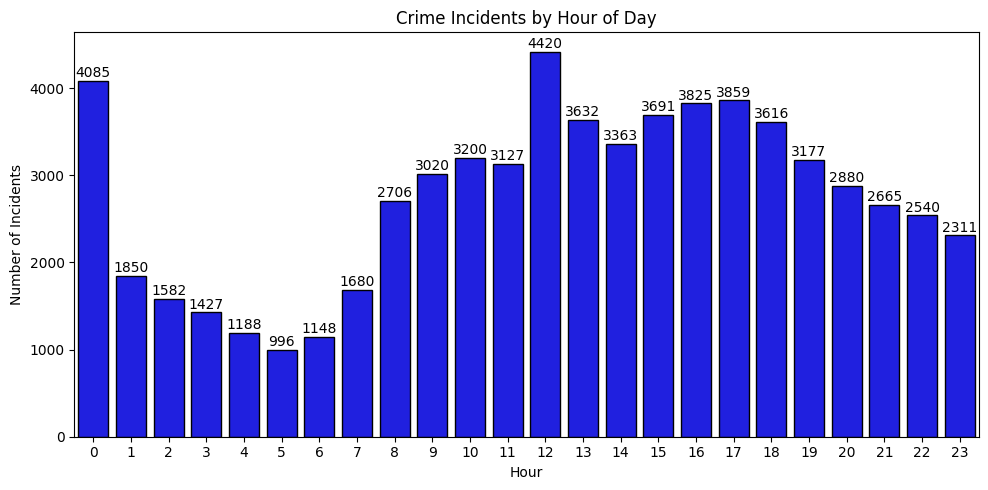

In [243]:
plt.figure(figsize=(10, 5))
hour_counts = df['incident_hour'].value_counts().sort_index()
ax = sns.barplot(x=hour_counts.index, y=hour_counts.values, color='blue', edgecolor='black')

for i, v in enumerate(hour_counts.values):
    ax.text(i, v + max(hour_counts.values)*0.01, str(v), color='black', ha='center')

plt.title("Crime Incidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Incidents")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig("outputs/crime_by_hour.png")
plt.show()

# 3. Crime by Weekday

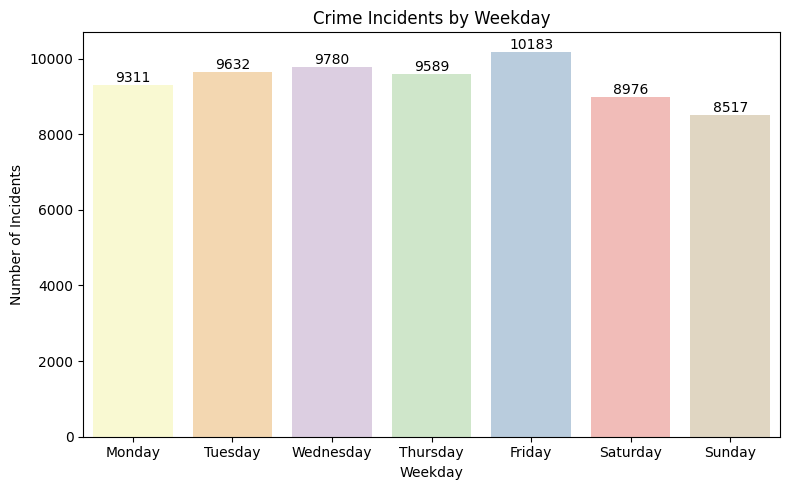

In [244]:
plt.figure(figsize=(8, 5))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.countplot(data=df, x='incident_day_of_week', hue='incident_day_of_week', order=weekday_order, palette='Pastel1')

for p in ax.patches:
    count = int(p.get_height())  
    ax.text(p.get_x() + p.get_width() / 2, count + 1, str(count), ha='center', va='bottom', color='black')


plt.title("Crime Incidents by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.savefig("outputs/crime_by_weekday.png")
plt.show()

# 4. Crime Location Density Heatmap

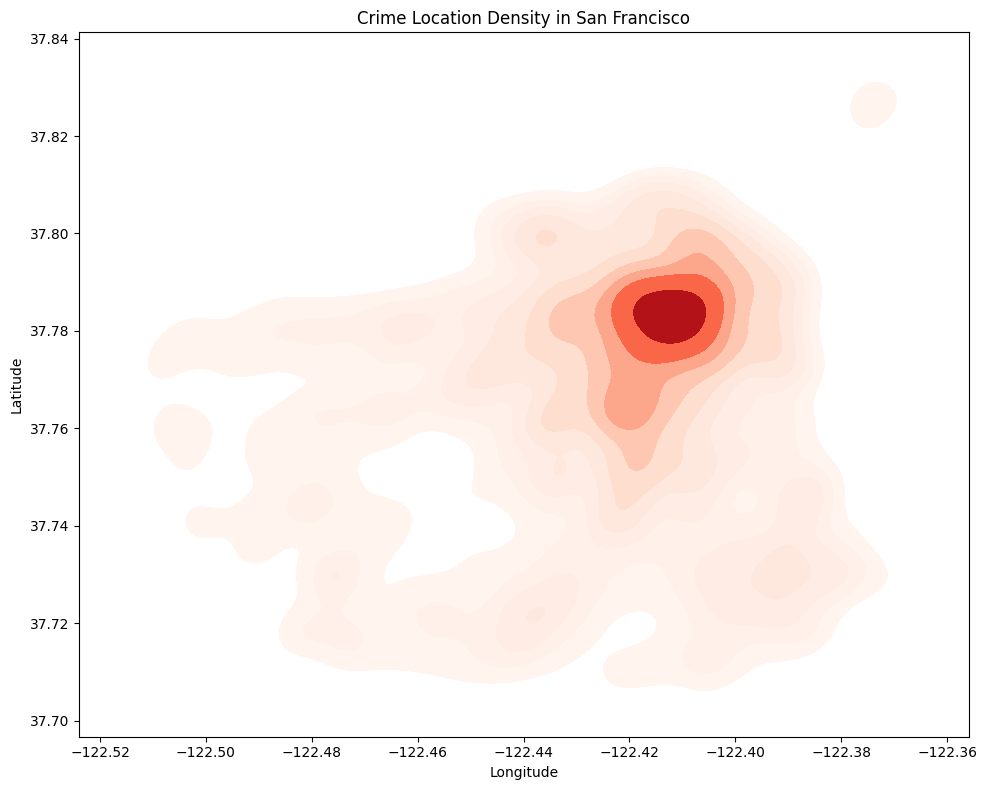

In [245]:
plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=df['longitude'], 
    y=df['latitude'], 
    cmap="Reds", 
    fill=True, 
    thresh=0.05
)
plt.title("Crime Location Density in San Francisco")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.savefig("outputs/crime_heatmap.png")
plt.show()

# 5. Top 11 Crime Heatmap <br>
(per category data that is more than2000)

In [ ]:
import contextily as ctx
from shapely.geometry import Point
import geopandas as gpd

top11 = df['incident_category'].value_counts().nlargest(11).index
df_top11 = df[df['incident_category'].isin(top11)]


In [ ]:
df['crime_type_violent'].value_counts().nlargest(11).index
df['crime_type_occupation'].value_counts().nlargest(11).index

Index(['Non-Violent', 'Violent'], dtype='object', name='crime_type_violent')

## Plot GeoGraph

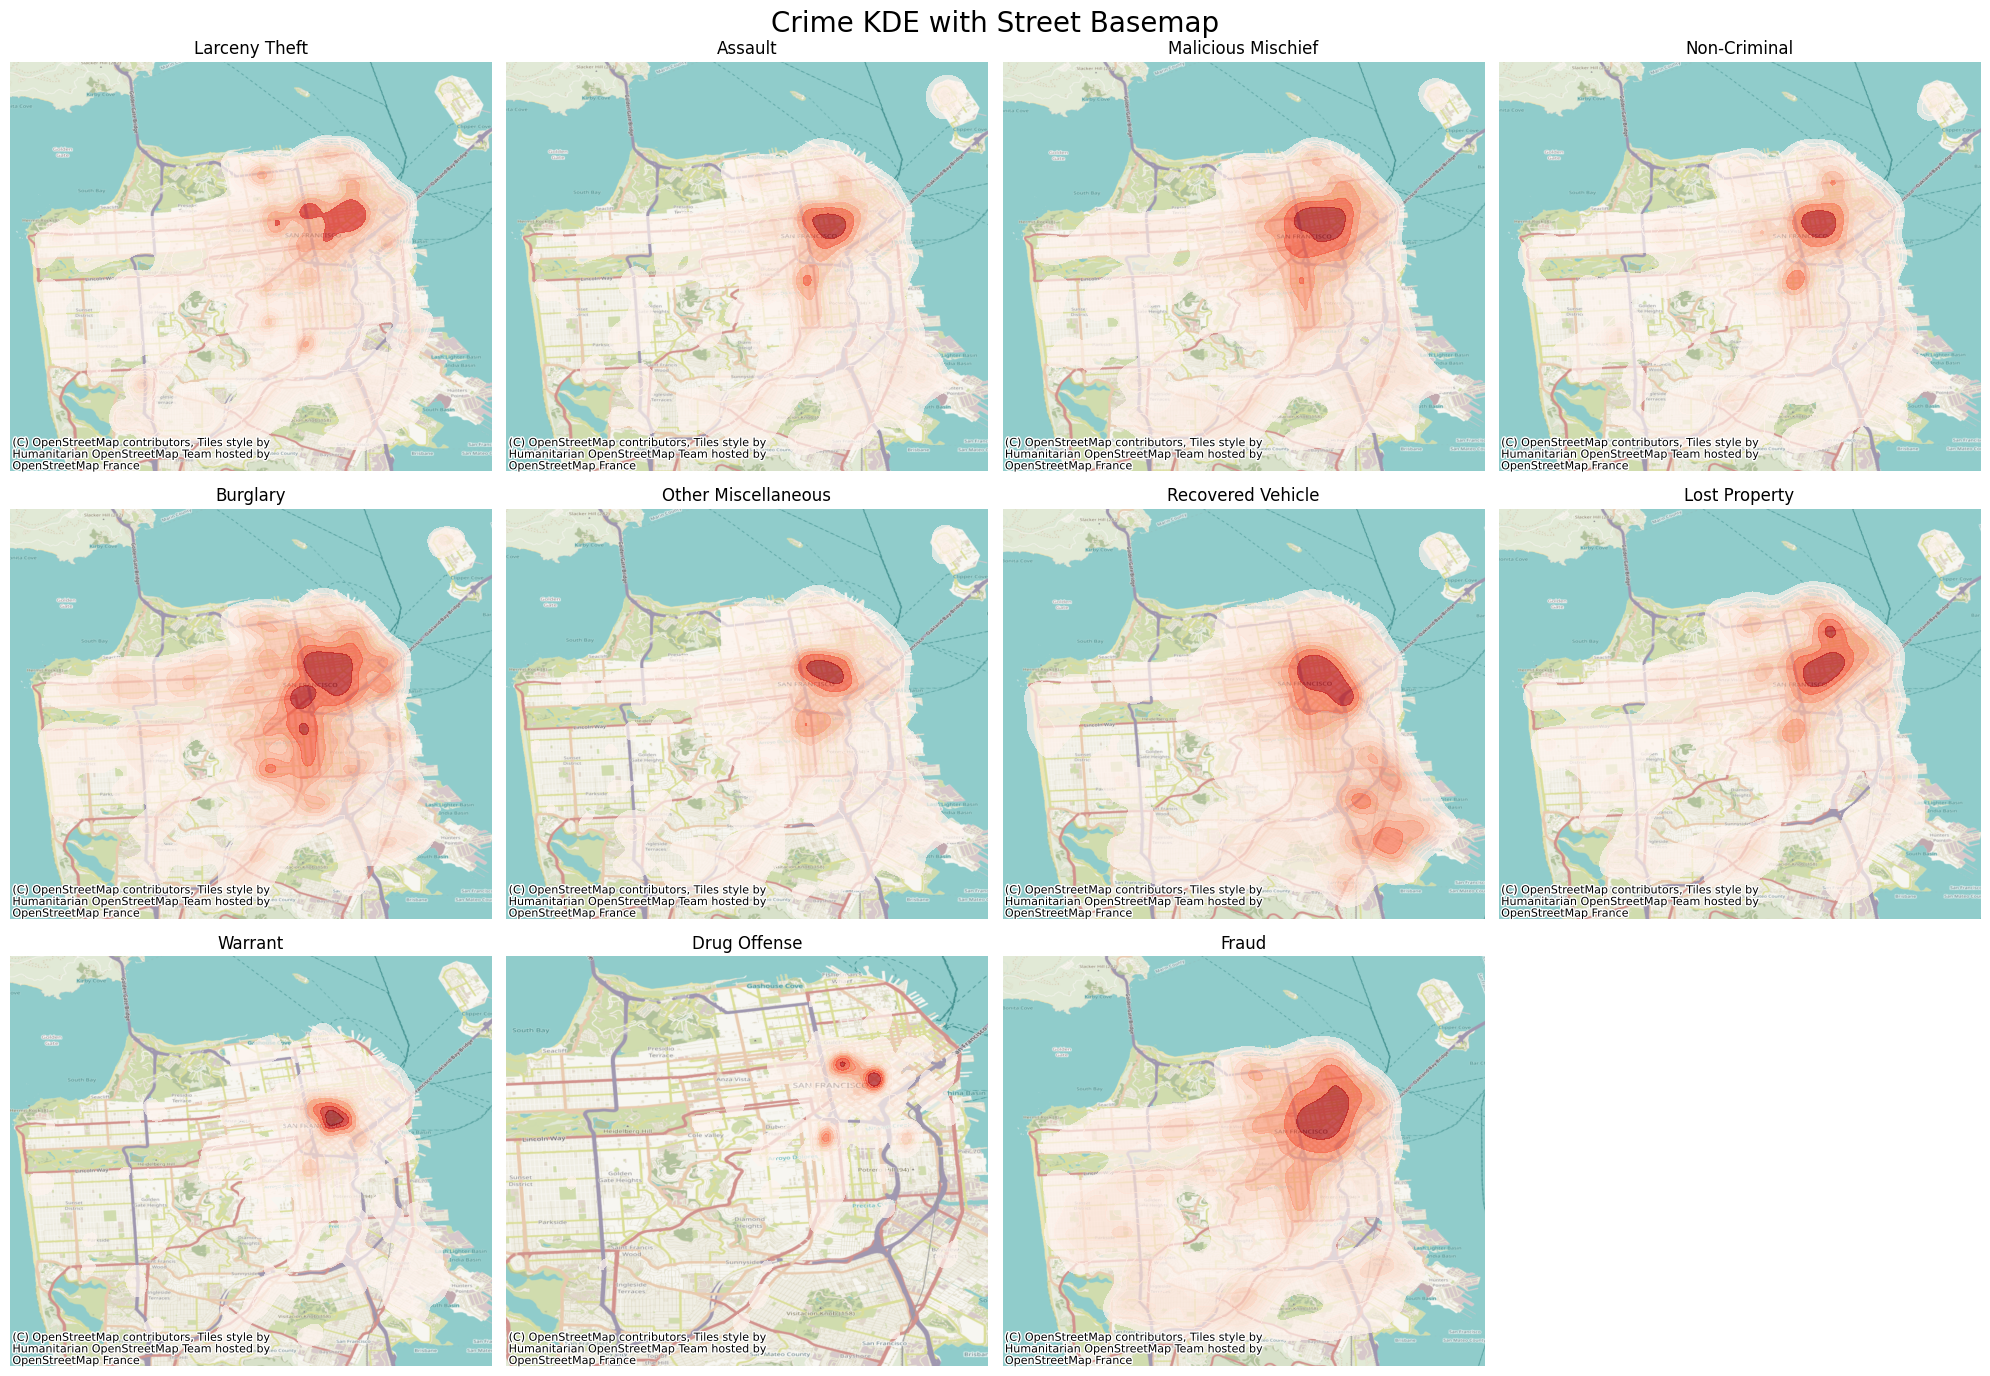

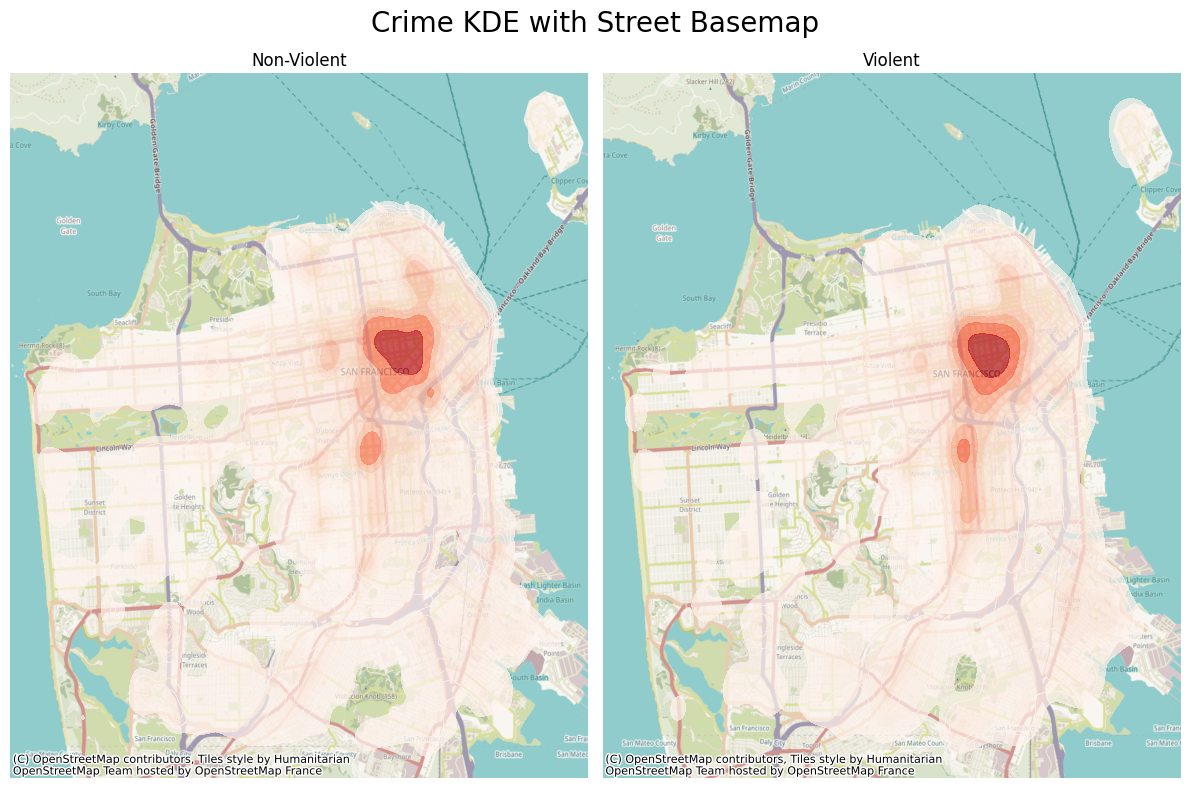

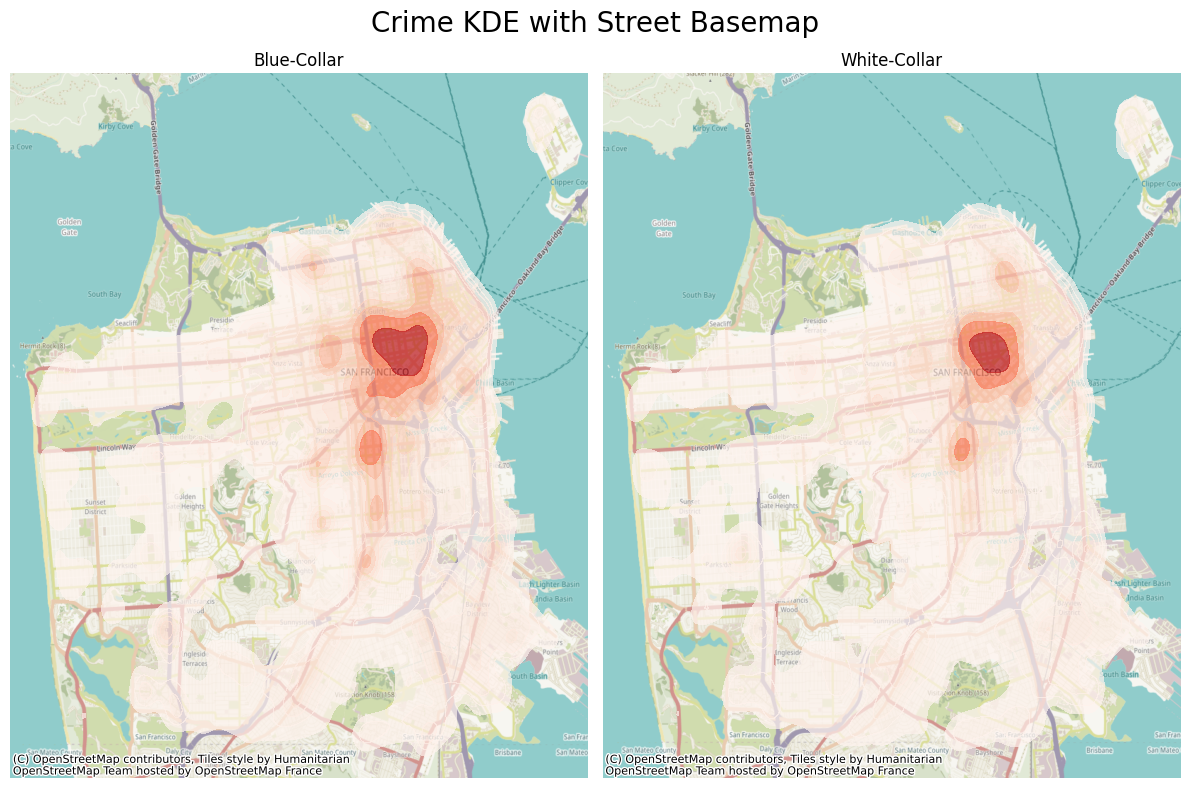

In [246]:
def plot_crime_geograph(df, col_name, img_name='org'):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs='EPSG:4326')
    gdf = gdf.to_crs(epsg=3857)  

    if img_name == 'org':
        fig, axes = plt.subplots(3, 4, figsize=(20, 14))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 8))
        
    axes = axes.flatten()

    top_index = df[col_name].value_counts().nlargest(11).index
    for i, crime in enumerate(top_index):
        ax = axes[i]
        gdf_cat = gdf[gdf[col_name] == crime]

        x = gdf_cat.geometry.x
        y = gdf_cat.geometry.y

        sns.kdeplot(x=x, y=y, fill=True, ax=ax, cmap="Reds", bw_adjust=0.5, thresh=0.05, alpha=0.7)
        ax.set_title(crime)
        ctx.add_basemap(ax,  alpha=1.0)
        ax.set_axis_off()  
        
    for j in range(len(top_index), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Crime KDE with Street Basemap", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"outputs/crime_basemap_{img_name}.png")

plot_crime_geograph(df_top11, 'incident_category', img_name='org')
plot_crime_geograph(df, 'crime_type_violent', img_name='violent')
plot_crime_geograph(df, 'crime_type_occupation', img_name='occupation')

## Monthly reports of the Crimes in San Francisco

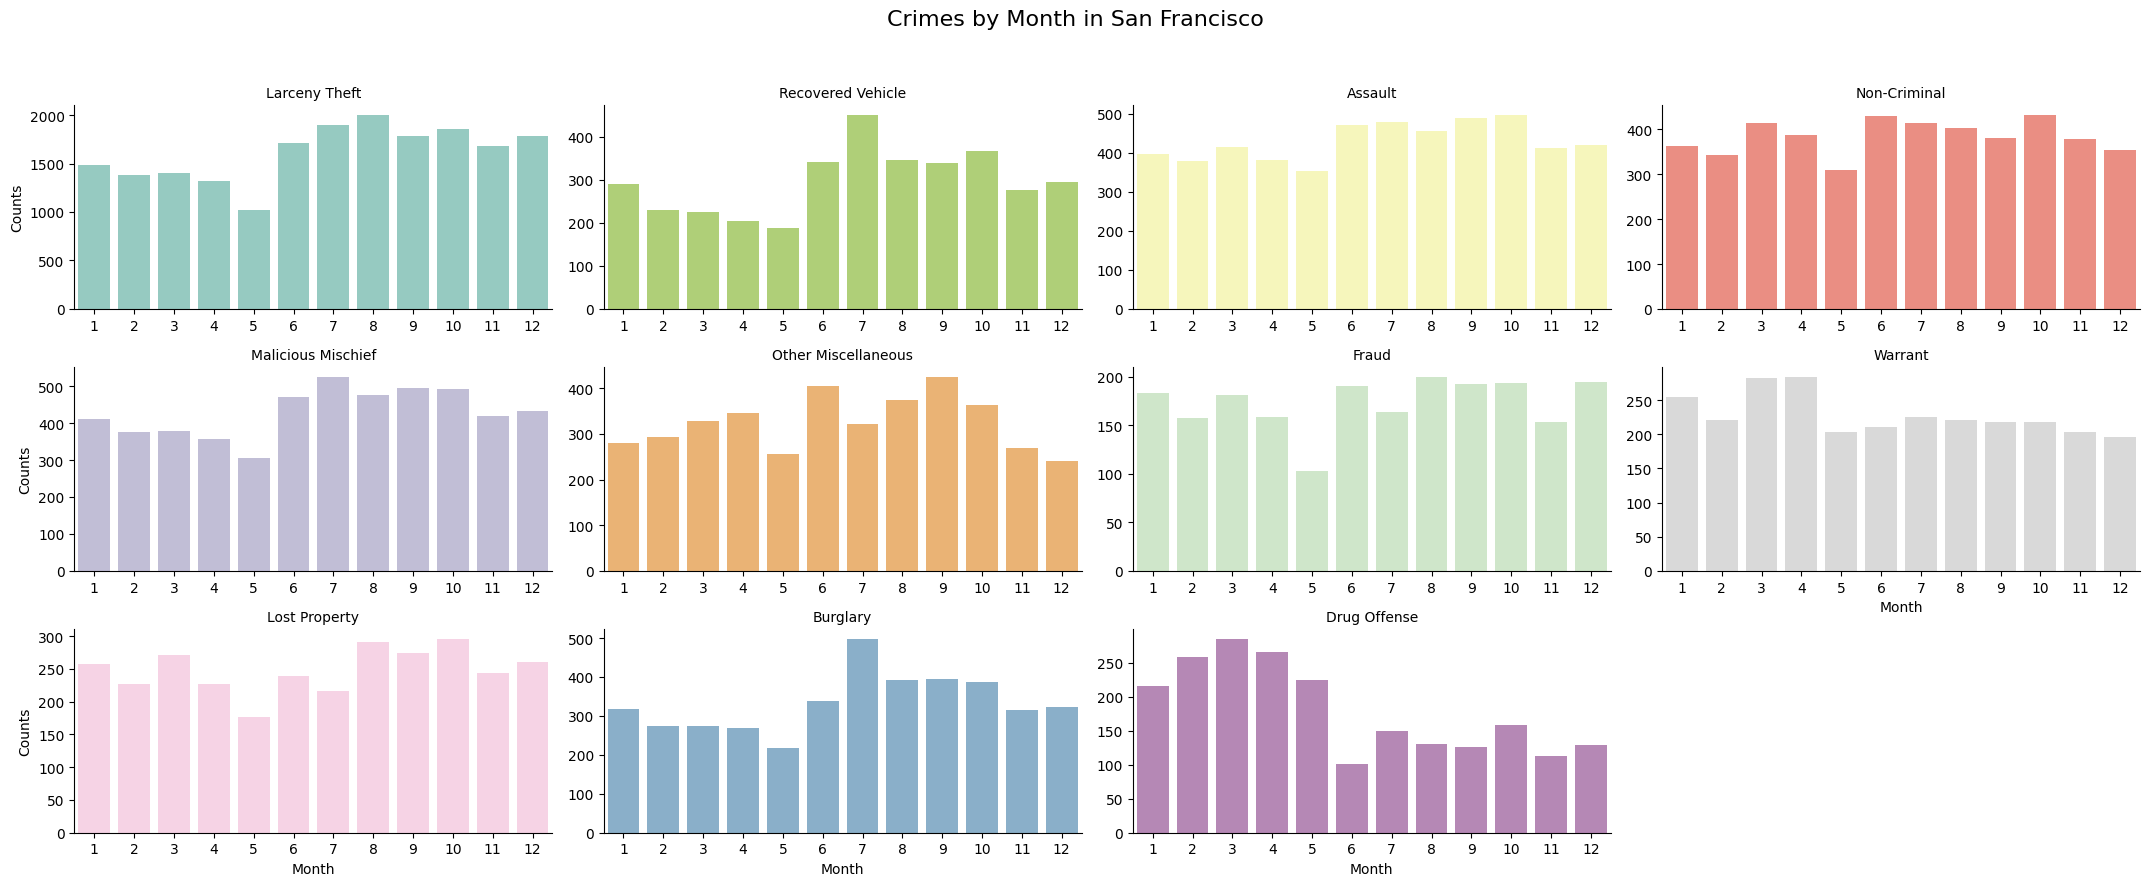

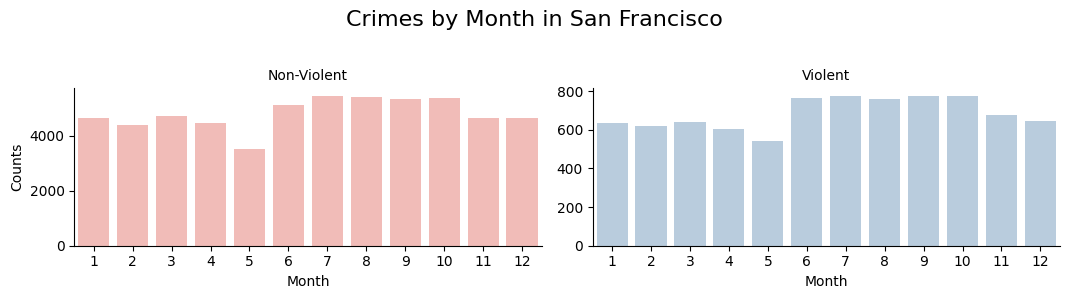

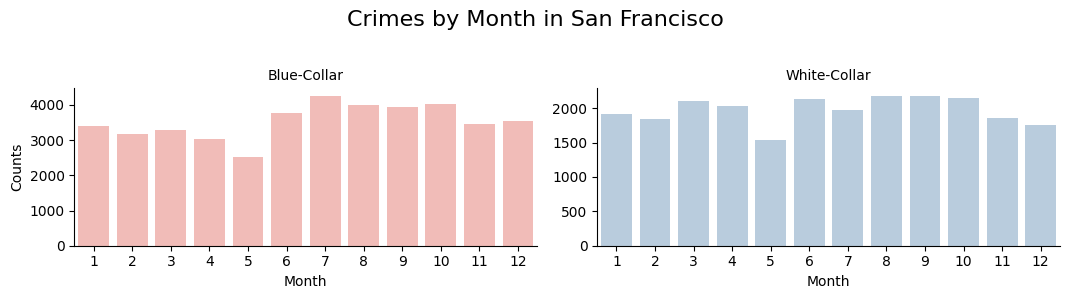

In [247]:
def plot_incidents_by_month(df, col_name, img_name='org'):
    unique_vals = df[col_name].nunique()
    col_wrap = min(unique_vals, 4)

    g = sns.FacetGrid(
        df,
        col=col_name,
        col_wrap=col_wrap,
        height=3,
        aspect=1.8,
        sharey=False,
        palette='husl'
    )

    if img_name == 'org':
        pattle = 'Set3'
    else:
        pattle = 'Pastel1'
        
    top_index = df[col_name].value_counts().nlargest(11).index
    category_colors = dict(zip(top_index, sns.color_palette(pattle, len(top_index))))

    def plot_colored_barplot(data, color, **kwargs):
        cat = data[col_name].iloc[0]
        sns.countplot(data=data, x="incident_month", order=list(range(1, 13)), color=category_colors[cat], **kwargs)

    g.map_dataframe(plot_colored_barplot)
    g.set_axis_labels("Month", "Counts")
    g.set_titles("{col_name}")
    for ax in g.axes.flatten():
        ax.set_xticks(range(0, 12))
        ax.set_xticklabels([str(i) for i in range(1, 13)])
        ax.tick_params(labelbottom=True)

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Crimes by Month in San Francisco", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"outputs/crime_month_{img_name}.png", dpi=300)
    plt.show()
    
plot_incidents_by_month(df_top11, 'incident_category', img_name='org')
plot_incidents_by_month(df, 'crime_type_violent', img_name='violent')
plot_incidents_by_month(df, 'crime_type_occupation', img_name='occupation')

## Daily reports of the Crimes in San Francisco

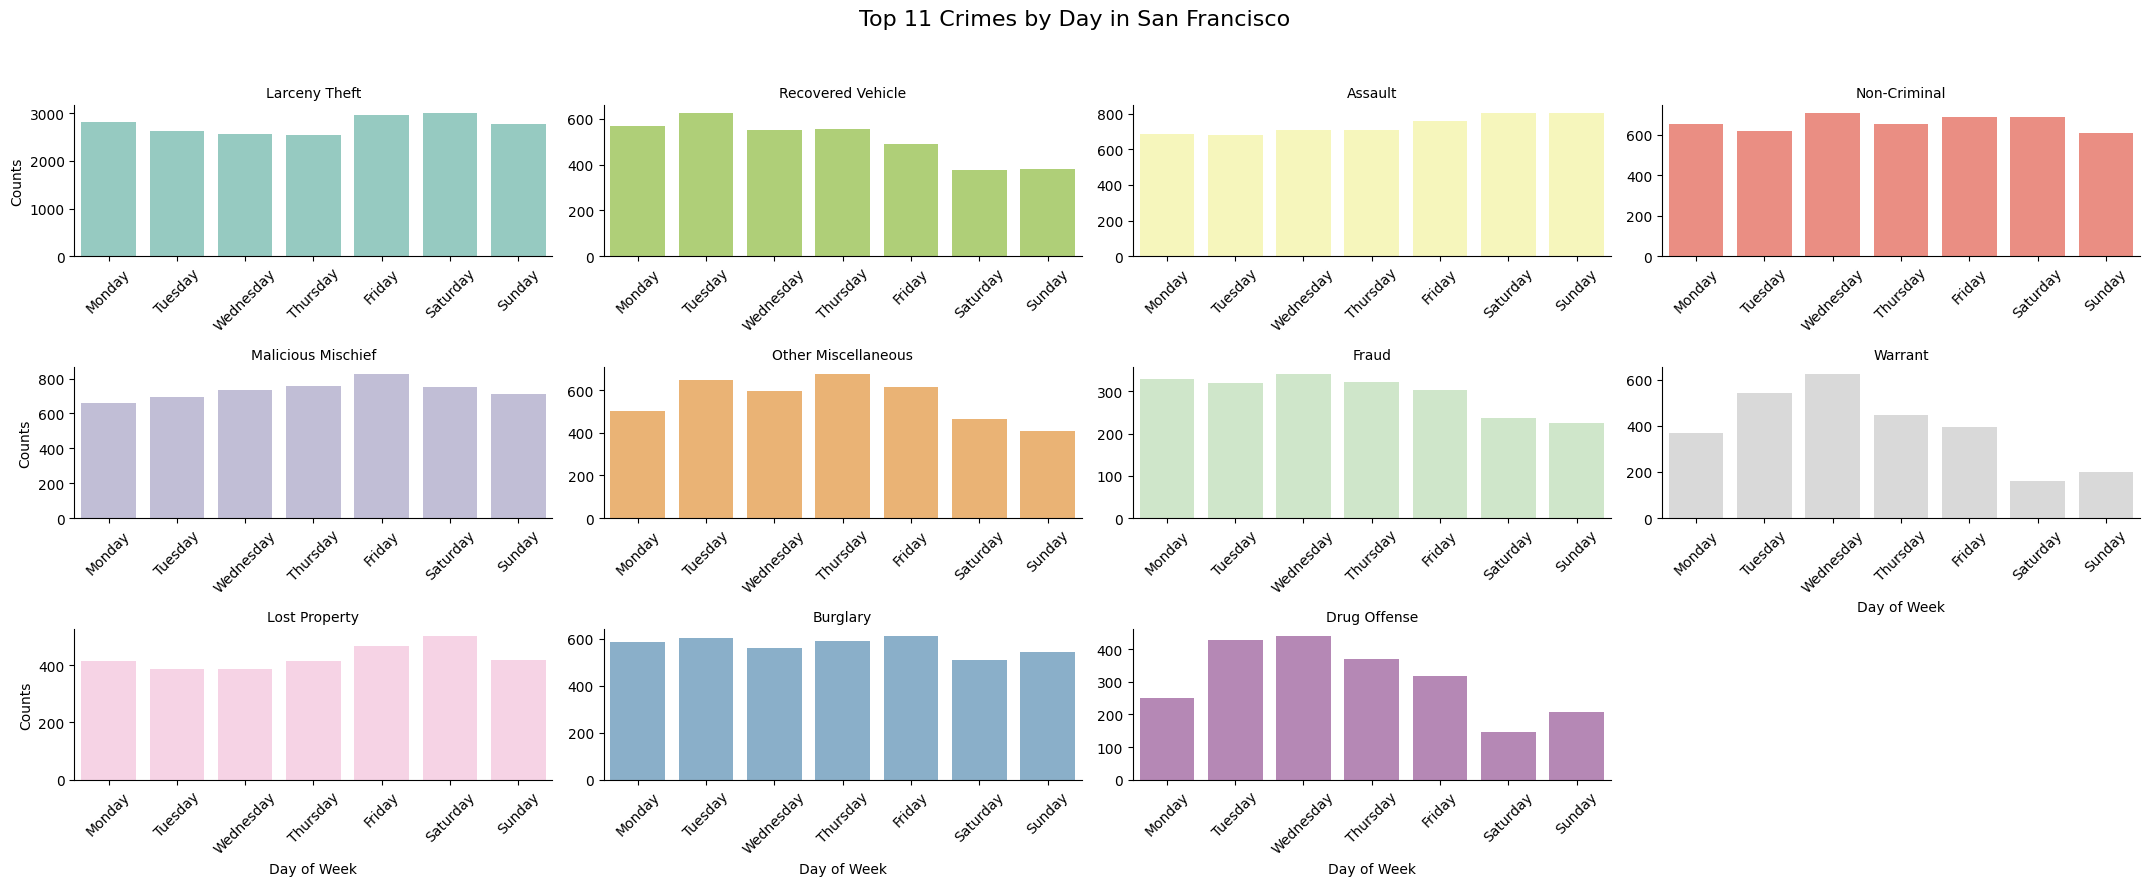

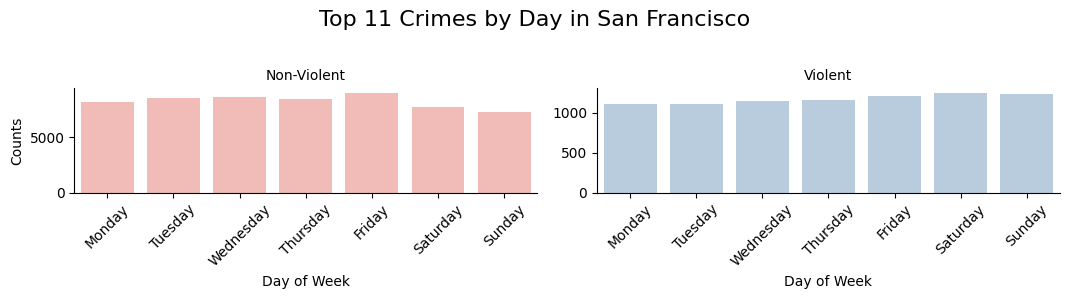

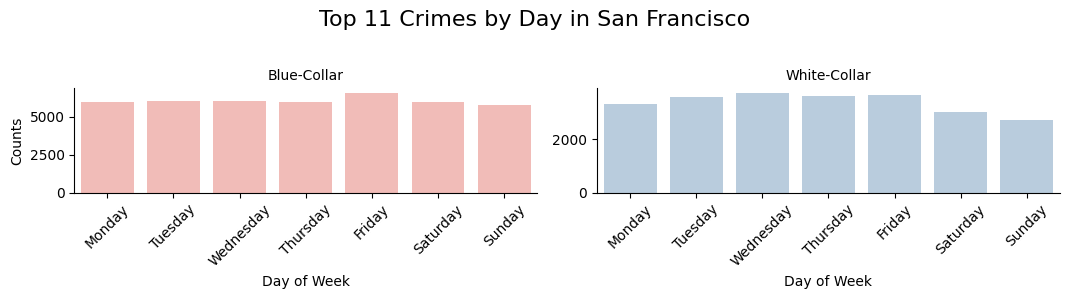

In [248]:
def plot_incidents_by_daily(df, col_name, img_name='org'):
    unique_vals = df[col_name].nunique()
    col_wrap = min(unique_vals, 4)


    g = sns.FacetGrid(
        df,
        col=col_name,
        col_wrap=col_wrap,
        height=3,
        aspect=1.8,
        sharey=False,
        palette='husl'
    )

    if img_name == 'org':
        pattle = 'Set3'
    else:
        pattle = 'Pastel1'

    top_index = df[col_name].value_counts().nlargest(11).index
    category_colors = dict(zip(top_index, sns.color_palette(pattle, len(top_index))))

    def plot_colored_barplot(data, color=None, **kwargs):
        cat = data[col_name].iloc[0]
        sns.countplot(
            data=data,
            x="incident_day_of_week",
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            color=category_colors[cat],
            **kwargs
        )

    g.map_dataframe(plot_colored_barplot)

    g.set_axis_labels("Day of Week", "Counts")
    g.set_titles("{col_name}")
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', labelbottom=True, labelrotation=45)


    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Top 11 Crimes by Day in San Francisco", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"outputs/crime_day_{img_name}.png", dpi=300)
    plt.show()
    
plot_incidents_by_daily(df_top11, 'incident_category', img_name='org')
plot_incidents_by_daily(df, 'crime_type_violent', img_name='violent')
plot_incidents_by_daily(df, 'crime_type_occupation', img_name='occupation')

## Hour reports of the Crimes in San Francisco

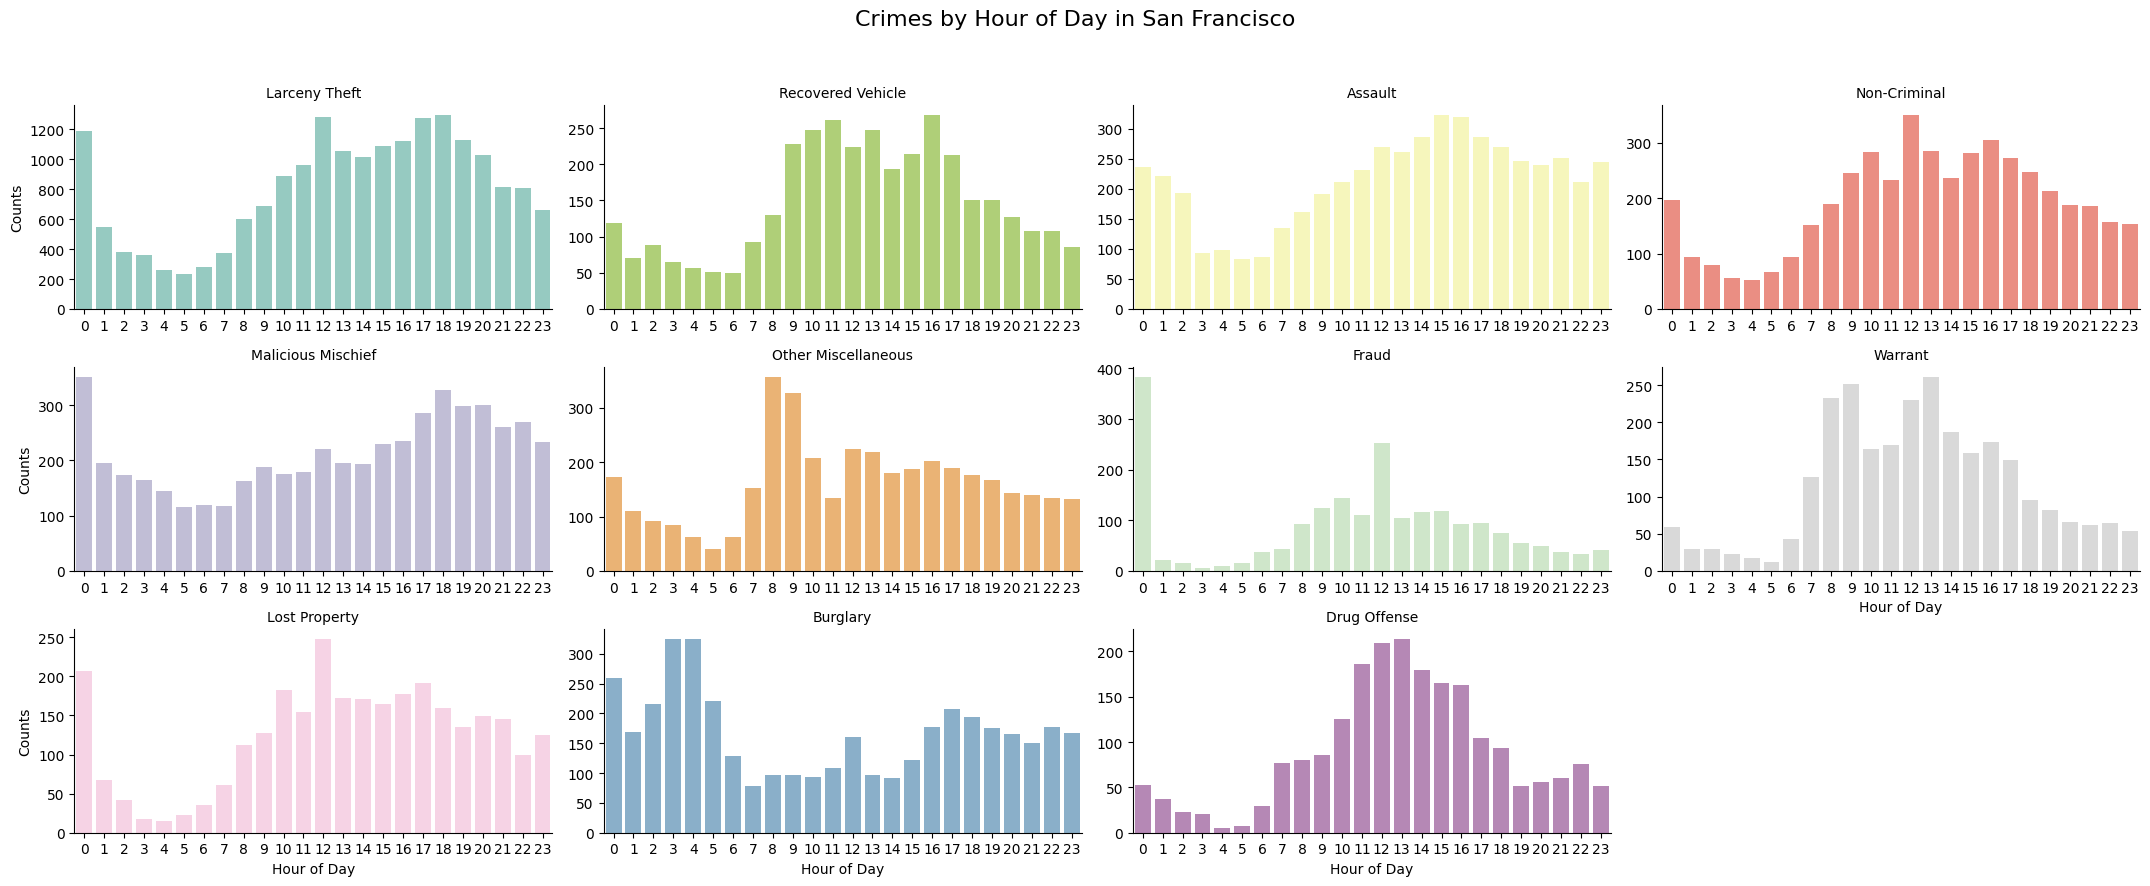

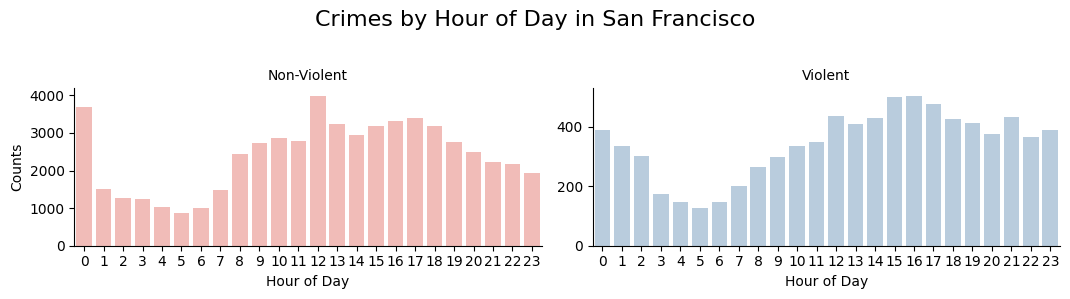

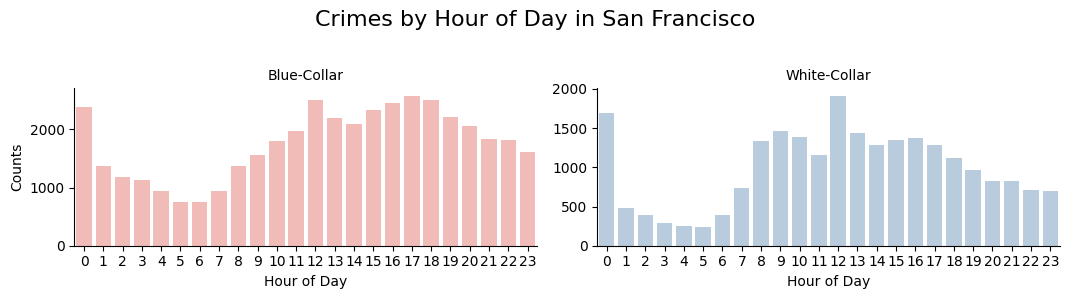

In [249]:
def plot_incidents_by_hour(df, col_name, img_name='org'):
    unique_vals = df[col_name].nunique()
    col_wrap = min(unique_vals, 4)

    if img_name == 'org':
        pattle = 'Set3'
    else:
        pattle = 'Pastel1'

    g = sns.FacetGrid(
        df,
        col=col_name,
        col_wrap=col_wrap,
        height=3,
        aspect=1.8,
        sharey=False,
        palette='husl'
    )

    top_index = df[col_name].value_counts().nlargest(11).index
    category_colors = dict(zip(top_index, sns.color_palette(pattle, len(top_index))))

    def plot_colored_hour_bar(data, color=None, **kwargs):
        cat = data[col_name].iloc[0]
        sns.countplot(
            data=data,
            x="incident_hour",
            order=list(range(24)),
            color=category_colors[cat],
            **kwargs
        )

    g.map_dataframe(plot_colored_hour_bar)

    g.set_axis_labels("Hour of Day", "Counts")
    g.set_titles("{col_name}")
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', labelbottom=True)
        ax.set_xticks(range(0, 24))
        ax.set_xticklabels([str(h) for h in range(24)], rotation=0)


    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Crimes by Hour of Day in San Francisco", fontsize=16, x=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"outputs/crime_hour_{img_name}.png", dpi=300)
    plt.show()

plot_incidents_by_hour(df_top11, 'incident_category', img_name='org')
plot_incidents_by_hour(df, 'crime_type_violent', img_name='violent')
plot_incidents_by_hour(df, 'crime_type_occupation', img_name='occupation')

## Seasonal patterns in data

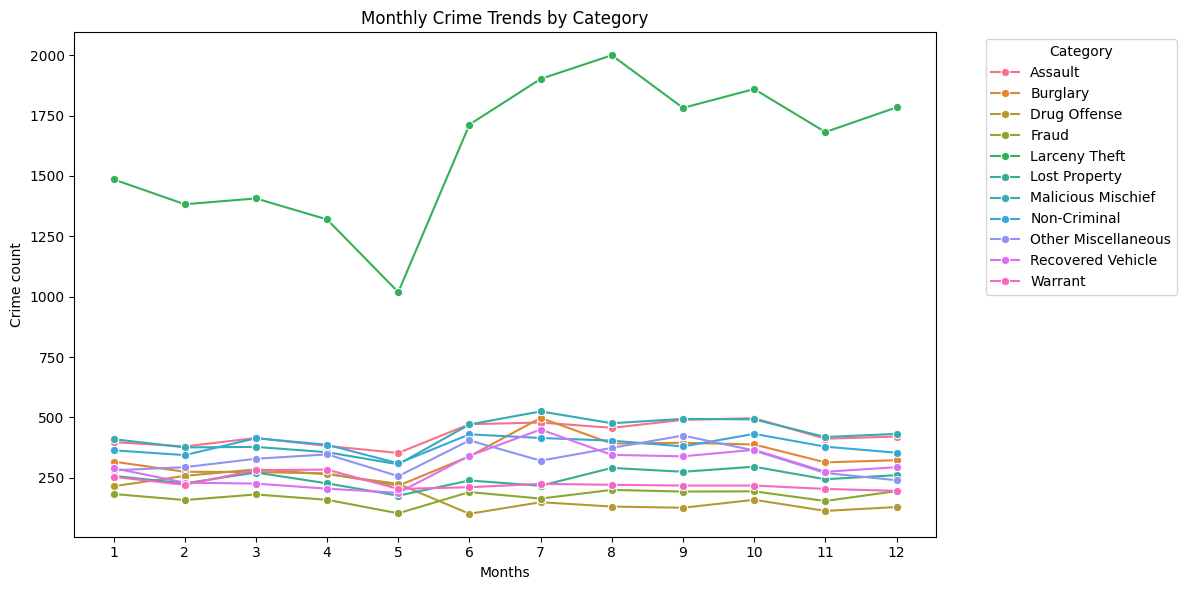

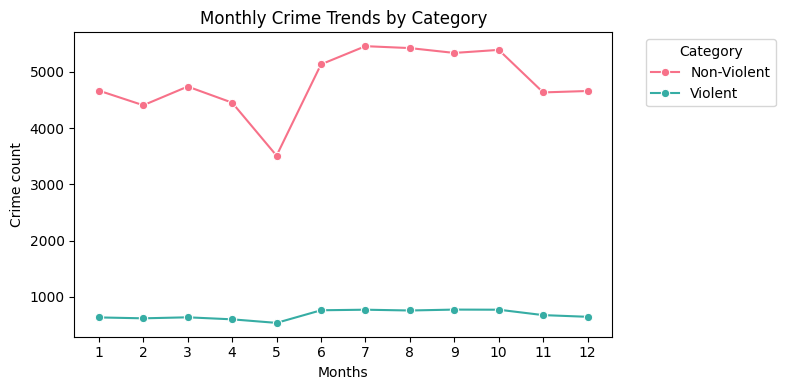

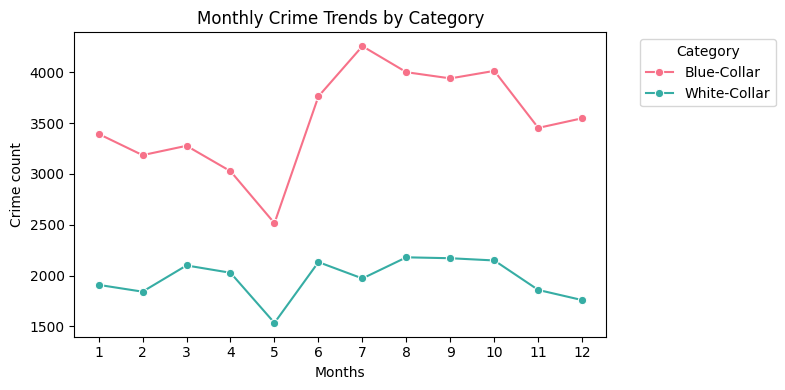

In [251]:
def plot_incidents_by_daily(df, col_name, img_name='org'):
    monthly_counts = df.groupby([col_name, 'incident_month']).size().reset_index(name='Count')
    if img_name == 'org':
        plt.figure(figsize=(12, 6))
    else:
        plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=monthly_counts,
        x='incident_month',
        y='Count',
        hue=col_name,
        marker='o',
        palette='husl'
    )

    plt.title("Monthly Crime Trends by Category")
    plt.xlabel("Months")
    plt.ylabel("Crime count")
    plt.xticks(range(1, 13))
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"outputs/crime_month_lineplot_{img_name}.png", dpi=300)
    plt.show()

plot_incidents_by_daily(df_top11, 'incident_category', img_name='org')
plot_incidents_by_daily(df, 'crime_type_violent', img_name='violent')
plot_incidents_by_daily(df, 'crime_type_occupation', img_name='occupation')